Bilayer higher domain. All PML profiles. Eigv plot

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


/home/srecondo/miniconda3/envs/cleaned-fenicsx/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
import dolfinx

In [3]:
dolfinx.__version__

'0.9.0'

Domain, PML, refinement and physical configurations

In [4]:
# Define element size for the mesh refinement
h_i = 0.125

# Domain configuration
Lx = 100 # fluid domain length (without PML)
l_inner=Lx/2 # interface position

# Physical configuration
rho_media_1 = 1020 # kg/m^3 about 1020 to 1029 is a normal rho for surface seawater
vel_media_1 = 1000   # m/s
rho_media_2 = 1020  # kg/m^3 about 1020 to 1029 is a normal rho for surface seawater
vel_media_2 = 1500  # m/s  

# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4
sigma_0 = (vel_media_1+vel_media_2)/2    #100/Lx
pml_type = ["piecewise-constant", "quadratic", "singular"]

# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [5]:
# Initialize dictionaries
dof = {}
solver_dict={}
V_dict={}
Q_dict={}


# Create mesh depending on h
mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i), [0, Lx + pml_thickness])

# Define finite element spaces
p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=1)
v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=0, shape=(mesh.geometry.dim,))
FE = {"p": p_fe_type, "v": v_fe_type}

# Create function spaces for mesh and submesh
Q = functionspace(mesh,FE["p"])
V = functionspace(mesh, FE["v"])

# Dictionaries to store the number of dofs
dof["p"] = Q.dofmap.index_map.size_global
dof["v"] = V.dofmap.index_map.size_global


# Boundary conditions application (for pressure)
bc = []
facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

# Setting to zero located dofs related to boundaries
u_d = Function(Q)
u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
bc.append(dirichletbc(u_d, o_boundary_dofs)) 
facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

# Setting to zero located dofs related to boundaries
u_d = Function(Q)
u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
bc.append(dirichletbc(u_d, o_boundary_dofs)) 

# Define differential operators
dx = Measure("dx", domain=mesh)
# Interpolates the density and velocity functions
W = functionspace(mesh, ("DG", 2))
rho = Function(W)
rho.interpolate(rho_function)
c = Function(W)
c.interpolate(vel_function)

# Spatial Coordinate is updated for the actual mesh
x = SpatialCoordinate(mesh)

# Variation formulation definition
p = TrialFunction(Q) 
v = TrialFunction(V)
q = TestFunction(Q)
w = TestFunction(V)


In [6]:

def get_solver(sigma_x):
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-7, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-30j)  
    solver.solve()
    n_eigs_converged_piecewise = solver.getConverged()

    return solver
# print(dof["p"], dof["v"])

Approx eigenvalues calculation

In [7]:
def get_approx_eigenpair(solver, selected_index, Q, V):
    
    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore
    omega_value = solver.getEigenpair(selected_index, vrA) * (1j)  # type: ignore
    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] = p_h.x.petsc_vec.array[:] / p_h.eval([Lx, 0.0, 0.0], 1)  # normalise
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] = v_h.x.petsc_vec.array[:] / v_h.eval([Lx, 0.0, 0.0], 1)  # normalise

    return [omega_value, p_h, v_h]  # Return eigenfunction and eigenvalue

In [8]:
def get_exact_eigenpair(solver, selected_index, Q, V):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))
    p = lambda x: np.where(x[0] == Lx + pml_thickness, 0, np.where(x[0] >= l_inner, p_2(x), p_1(x)))

    sigma_x = lambda x: np.where(x[0] >= l_inner, sigma_0, 0)
    sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, x[0]*0.0+1e10, sigma_x(x)))
    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)
        * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))* gamma_x(x, w)[0])
    v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))

    Q = functionspace(mesh, FE["p"])
    V = functionspace(mesh, FE["v"])

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)
    p_ex.x.petsc_vec.array[:] = p_ex.x.petsc_vec.array[:] / p_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)
    v_ex.x.petsc_vec.array[:] = v_ex.x.petsc_vec.array[:] / v_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    return [w, p_ex, v_ex]

Piecewise-constant

In [9]:
# Define piecewise-constant stretching function
x_hat_piecewise = lambda x, w: np.where(x[0] <= Lx, x[0], x[0]+  1j / w * (x[0] - Lx) * sigma_0)

#Define sigma and gamma piecewise-constant functions
gamma_x_piecewise = lambda x, omega: 1.0 + (x[0] >= Lx) * 1j / omega * sigma_0
sigma_x_piecewise = lambda x: conditional(x[0] > Lx, sigma_0, 0.0)
# Define solver for piecewise-constant PML
solver_piecewise=get_solver(sigma_x_piecewise)


Quadratic

In [10]:
# Define quadratic sigma function
sigma_x_quadratic= lambda x: conditional(x[0] >= Lx, sigma_0 * ( x[0] - Lx) ** 2, 0.0 )
# Define solver for quadratic PML
solver_quadratic=get_solver(sigma_x_quadratic)

Singular

In [11]:
# Define singular sigma function
sigma_x_singular=lambda x: conditional(x[0] > Lx, sigma_0 / (Lx + pml_thickness - x[0]), 0.0)
# Define solver for singular PML
solver_singular=get_solver(sigma_x_singular)

Plot of eigenvalues

In [12]:
eig_number = 0

# Get the approximated eigenpair
[omega_h_piecewise, p_h_piecewise, v_h_piecewise] = get_approx_eigenpair(solver_piecewise, eig_number, Q, V)
[omega_h_quadratic, p_h_quadratic, v_h_quadratic] = get_approx_eigenpair(solver_quadratic, eig_number, Q, V)
[omega_h_singular, p_h_singular, v_h_singular] = get_approx_eigenpair(solver_singular, eig_number, Q, V)
# Get the exact eigenpair
[omega_ex, p_ex, v_ex] = get_exact_eigenpair(solver_piecewise, eig_number, Q, V)


NameError: name 'x_hat' is not defined

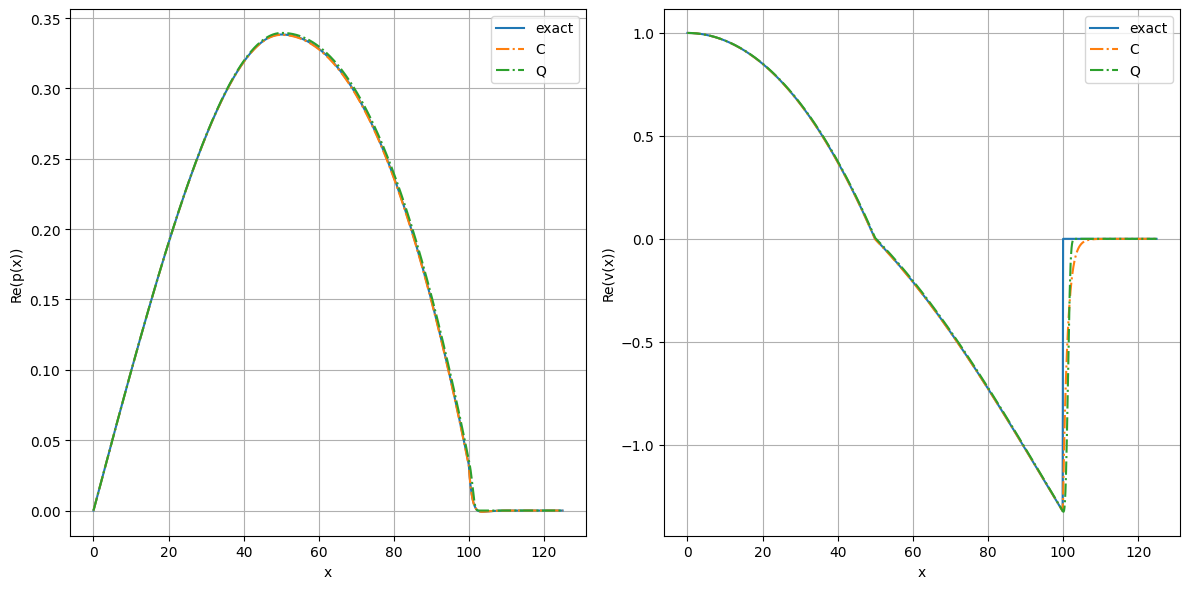

In [49]:
# Crear una figura con dos subgráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subgráfico 1: Representación de p(x)
ax1.grid(True)
ax1.plot(mesh.geometry.x[:, 0], np.real(p_ex.x.petsc_vec.array), "-", label="exact")
ax1.plot(mesh.geometry.x[:, 0], np.real(p_h_piecewise.x.petsc_vec.array), "-.", label="C")
ax1.plot(mesh.geometry.x[:, 0], np.real(p_h_quadratic.x.petsc_vec.array), "-.", label="Q")
# ax1.plot(mesh.geometry.x[:, 0], np.real(p_h_singular.x.petsc_vec.array), "-.", label="S")
ax1.set_xlabel("x")
ax1.set_ylabel("Re(p(x))")
ax1.legend()

# Subgráfico 2: Representación de v(x)
dofmap = functionspace(mesh, FE["v"]).dofmap.index_map.local_range  # Rango local de DoFs
local_coords = mesh.geometry.x[dofmap[0]:dofmap[1], :]  # Coordenadas locales
x_coord = [x[0] for x in local_coords]

ax2.grid(True)
ax2.plot(x_coord, np.real(v_ex.x.petsc_vec.array), "-", label="exact")
ax2.plot(x_coord, np.real(v_h_piecewise.x.petsc_vec.array), "-.", label="C")
ax2.plot(x_coord, np.real(v_h_quadratic.x.petsc_vec.array), "-.", label="Q")
# ax2.plot(x_coord, np.real(v_h_singular.x.petsc_vec.array), "-.", label="S")
ax2.set_xlabel("x")
ax2.set_ylabel("Re(v(x))")
ax2.legend()

plt.tight_layout()  # Ajustar el espaciado entre subgráficas
plt.show()

